<h1 style=font-size:40px>Predicting Material Backorders in Inventory Management</h1>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import accuracy_score, roc_curve, auc

import warnings
warnings.filterwarnings("ignore")

In [2]:
#constants calculated from eda & feature engineering
lead_time_mean = float(np.load('lead_time_mean.npy'))
potential_issue_probability_matrix = pd.read_csv('potential_issue_probability_matrix.csv')
deck_risk_probability_matrix = pd.read_csv('deck_risk_probability_matrix.csv')
oe_constraint_probability_matrix = pd.read_csv('oe_constraint_probability_matrix.csv')
ppap_risk_probability_matrix = pd.read_csv('ppap_risk_probability_matrix.csv')
stop_auto_buy_probability_matrix = pd.read_csv('stop_auto_buy_probability_matrix.csv')
rev_stop_probability_matrix = pd.read_csv('rev_stop_probability_matrix.csv')

In [3]:
data = pd.read_csv("test_dataset_v2.csv")

In [4]:
y = data['went_on_backorder']

In [5]:
x = data.drop('went_on_backorder', axis=1)

# final_func_1

In [6]:
def final_fun_1(x):
    """
    Takes the dataframe as input and predicts if the products have gone into backorder or not. 0 indicates the product has not gone into backorder
    and 1 indicates, the product has gone into backorder.
    """    
    if type(x) == dict:
        dataframe = pd.DataFrame(x, index=[0], columns=['sku', 'national_inv', 'lead_time', 'in_transit_qty',
                                                    'forecast_3_month', 'forecast_6_month', 'forecast_9_month',
                                                    'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month',
                                                    'min_bank', 'potential_issue', 'pieces_past_due', 'perf_6_month_avg',
                                                    'perf_12_month_avg', 'local_bo_qty', 'deck_risk', 'oe_constraint',
                                                    'ppap_risk', 'stop_auto_buy', 'rev_stop'])
    else:
        dataframe = x
    
    dataframe = dataframe.drop('sku', axis=1) #dropping sku column
    
    if dataframe.iloc[-1].isna().all() == True:
        dataframe = dataframe[:-1] #removing last row as there are NaN values

    dataframe = dataframe.fillna(lead_time_mean) #mean imputation
    dataframe.replace({'Yes': 1, 'No': 0}, inplace=True) #converting categorical features into binary features
    
    #adding binary_pieces_past_due
    conditions = [dataframe['pieces_past_due'] == 0, dataframe['pieces_past_due'] > 0]
    values = [0, 1]
    dataframe['binary_pieces_past_due'] = np.select(conditions, values)
    
    #adding binary_local_bo_qty
    conditions = [dataframe['local_bo_qty'] == 0, dataframe['local_bo_qty'] > 0]
    values = [0, 1]
    dataframe['binary_local_bo_qty'] = np.select(conditions, values)
    
    #imputing all categorical features
    conditions_pt = [dataframe['potential_issue'] == 0, dataframe['potential_issue'] == 1]
    values_pt = [potential_issue_probability_matrix['No'][0], potential_issue_probability_matrix['No'][1]]
    dataframe['potential_issue'] = np.select(conditions_pt, values_pt)

    conditions_dr = [dataframe['deck_risk'] == 0, dataframe['deck_risk'] == 1]
    values_dr = [deck_risk_probability_matrix['No'][0], deck_risk_probability_matrix['No'][1]]
    dataframe['deck_risk'] = np.select(conditions_dr, values_dr)

    conditions_oe = [dataframe['oe_constraint'] == 0, dataframe['oe_constraint'] == 1]
    values_oe = [oe_constraint_probability_matrix['No'][0], oe_constraint_probability_matrix['No'][1]]
    dataframe['oe_constraint'] = np.select(conditions_oe, values_oe)

    conditions_pp = [dataframe['ppap_risk'] == 0, dataframe['ppap_risk'] == 1]
    values_pp = [ppap_risk_probability_matrix['No'][0], ppap_risk_probability_matrix['No'][1]]
    dataframe['ppap_risk'] = np.select(conditions_pp, values_pp)

    conditions_stp = [dataframe['stop_auto_buy'] == 0, dataframe['stop_auto_buy'] == 1]
    values_stp = [stop_auto_buy_probability_matrix['No'][0], stop_auto_buy_probability_matrix['No'][1]]
    dataframe['stop_auto_buy'] = np.select(conditions_stp, values_stp)

    conditions_rev = [dataframe['rev_stop'] == 0, dataframe['rev_stop'] == 1]
    values_rev = [rev_stop_probability_matrix['No'][0], rev_stop_probability_matrix['No'][1]]
    dataframe['rev_stop'] = np.select(conditions_rev, values_rev)

    filename = 'best_model_forest.h5'
    best_model = pickle.load(open(filename, 'rb'))
    predictions = best_model.predict(dataframe)
    if len(predictions) == 1:
        predictions = int(predictions)
    return predictions

In [7]:
a = final_fun_1(x) #taking entire dataframe as input

In [8]:
one_datapoint = dict(x.loc[0])

In [9]:
print(one_datapoint)

{'sku': 3285085, 'national_inv': 62.0, 'lead_time': nan, 'in_transit_qty': 0.0, 'forecast_3_month': 0.0, 'forecast_6_month': 0.0, 'forecast_9_month': 0.0, 'sales_1_month': 0.0, 'sales_3_month': 0.0, 'sales_6_month': 0.0, 'sales_9_month': 0.0, 'min_bank': 1.0, 'potential_issue': 'No', 'pieces_past_due': 0.0, 'perf_6_month_avg': -99.0, 'perf_12_month_avg': -99.0, 'local_bo_qty': 0.0, 'deck_risk': 'Yes', 'oe_constraint': 'No', 'ppap_risk': 'No', 'stop_auto_buy': 'Yes', 'rev_stop': 'No'}


In [10]:
final_fun_1(one_datapoint) #taking one datapoint(dict) as input

0

# final_func_2

In [11]:
def final_fun_2(x, y):
    """
    Takes the input dataframe and the target label as input and makes prediction. These predictions and then used to compute the performance
    of the model. Metrics shown are accuracy, precision, recall, AUC and confusion matrix.
    """
    if np.isnan(y.iloc[-1]) == True:
        y = y[:-1]
        y.replace({'Yes': 1, 'No': 0}, inplace=True)
    else:
        y.replace({'Yes': 1, 'No': 0}, inplace=True)
        
    x = x.drop('sku', axis=1)
    #removing last row if they are all NaN
    if x.iloc[-1].isna().all() == True:
        x = x[:-1]
    
    x = x.fillna(lead_time_mean) #mean imputation
    x.replace({'Yes': 1, 'No': 0}, inplace=True) #converting categorical features into binary features
    
    #adding binary_pieces_past_due
    conditions = [x['pieces_past_due'] == 0, x['pieces_past_due'] > 0]
    values = [0, 1]
    x['binary_pieces_past_due'] = np.select(conditions, values)
    
    #adding binary_local_bo_qty
    conditions = [x['local_bo_qty'] == 0, x['local_bo_qty'] > 0]
    values = [0, 1]
    x['binary_local_bo_qty'] = np.select(conditions, values)
    
    #imputing all categorical features
    conditions_pt = [x['potential_issue'] == 0, x['potential_issue'] == 1]
    values_pt = [potential_issue_probability_matrix['No'][0], potential_issue_probability_matrix['No'][1]]
    x['potential_issue'] = np.select(conditions_pt, values_pt)

    conditions_dr = [x['deck_risk'] == 0, x['deck_risk'] == 1]
    values_dr = [deck_risk_probability_matrix['No'][0], deck_risk_probability_matrix['No'][1]]
    x['deck_risk'] = np.select(conditions_dr, values_dr)

    conditions_oe = [x['oe_constraint'] == 0, x['oe_constraint'] == 1]
    values_oe = [oe_constraint_probability_matrix['No'][0], oe_constraint_probability_matrix['No'][1]]
    x['oe_constraint'] = np.select(conditions_oe, values_oe)

    conditions_pp = [x['ppap_risk'] == 0, x['ppap_risk'] == 1]
    values_pp = [ppap_risk_probability_matrix['No'][0], ppap_risk_probability_matrix['No'][1]]
    x['ppap_risk'] = np.select(conditions_pp, values_pp)

    conditions_stp = [x['stop_auto_buy'] == 0, x['stop_auto_buy'] == 1]
    values_stp = [stop_auto_buy_probability_matrix['No'][0], stop_auto_buy_probability_matrix['No'][1]]
    x['stop_auto_buy'] = np.select(conditions_stp, values_stp)

    conditions_rev = [x['rev_stop'] == 0, x['rev_stop'] == 1]
    values_rev = [rev_stop_probability_matrix['No'][0], rev_stop_probability_matrix['No'][1]]
    x['rev_stop'] = np.select(conditions_rev, values_rev)

    filename = 'best_model_forest.h5'
    best_model = pickle.load(open(filename, 'rb'))
    predictions = best_model.predict(x)
    
    #printing metrics
    print('Accuracy:', accuracy_score(y, predictions))
    #plotting confurion matrix
    y_pred = best_model.predict_proba(x)[:,1]
    fpr, tpr, thresholds = roc_curve(y, y_pred)
    print('AUC:', auc(fpr, tpr))
    plt.plot(fpr, tpr, label="AUC ="+' '+str(auc(fpr, tpr)))
    plt.legend()
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC-AUC Curve")
    plt.grid()
    plt.show()

Accuracy: 0.9381927088712176
AUC: 0.9259680311686973


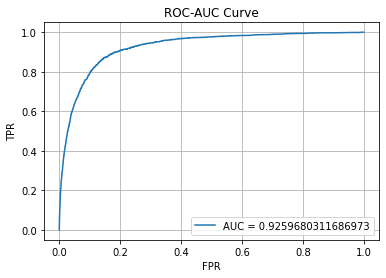

In [12]:
final_fun_2(x, y)